# Time Series Analysis
by Chee-Foong
on 18 Mar 2020

Time series provide the opportunity to forecast future values.  In this analysis, using time series data from Energy Authority of Singapore, we attempt to forecast electricity system demand for every half hour period (MW) in Singapore.

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus first on ARIMA and then SARIMA, which is used to fit time-series data to better understand and forecast future points in the time series.

## Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge import *

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':120})

## Data Preparation
<span style="color:red">*Refer to data exploratory notebook for data sanity check and analysis*</span>


In [3]:
full_data = pd.read_csv('../data/full_data_cleaned.csv', parse_dates=['datetime'], index_col='datetime')
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)
full_data.shape

(29568, 3)

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29568 entries, 2014-09-29 00:30:00 to 2016-06-06 00:00:00
Data columns (total 3 columns):
system_demand_actual    29568 non-null int64
nem_demand_actual       29568 non-null int64
nem_demand_forecast     29568 non-null int64
dtypes: int64(3)
memory usage: 924.0 KB


## Time Series Analysis
The analysis follows the **Box-Jenkins Method** documented here: 
- https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf

For simplicity, the following analysis will focus on 1 week of weekdays data and to build a model based on data from Mon to Thu and forecast the energy demand for Fri.

The model will serve as a baseline model which can be finetuned to predict energy demand over weekends/holidays.

In [6]:
demand_data_analysis = full_data['2015-05-04':'2015-05-07'].copy()
demand_data_analysis.shape

(192, 3)

Check whether the time series is stationary using the **augmented dicky-fuller test**

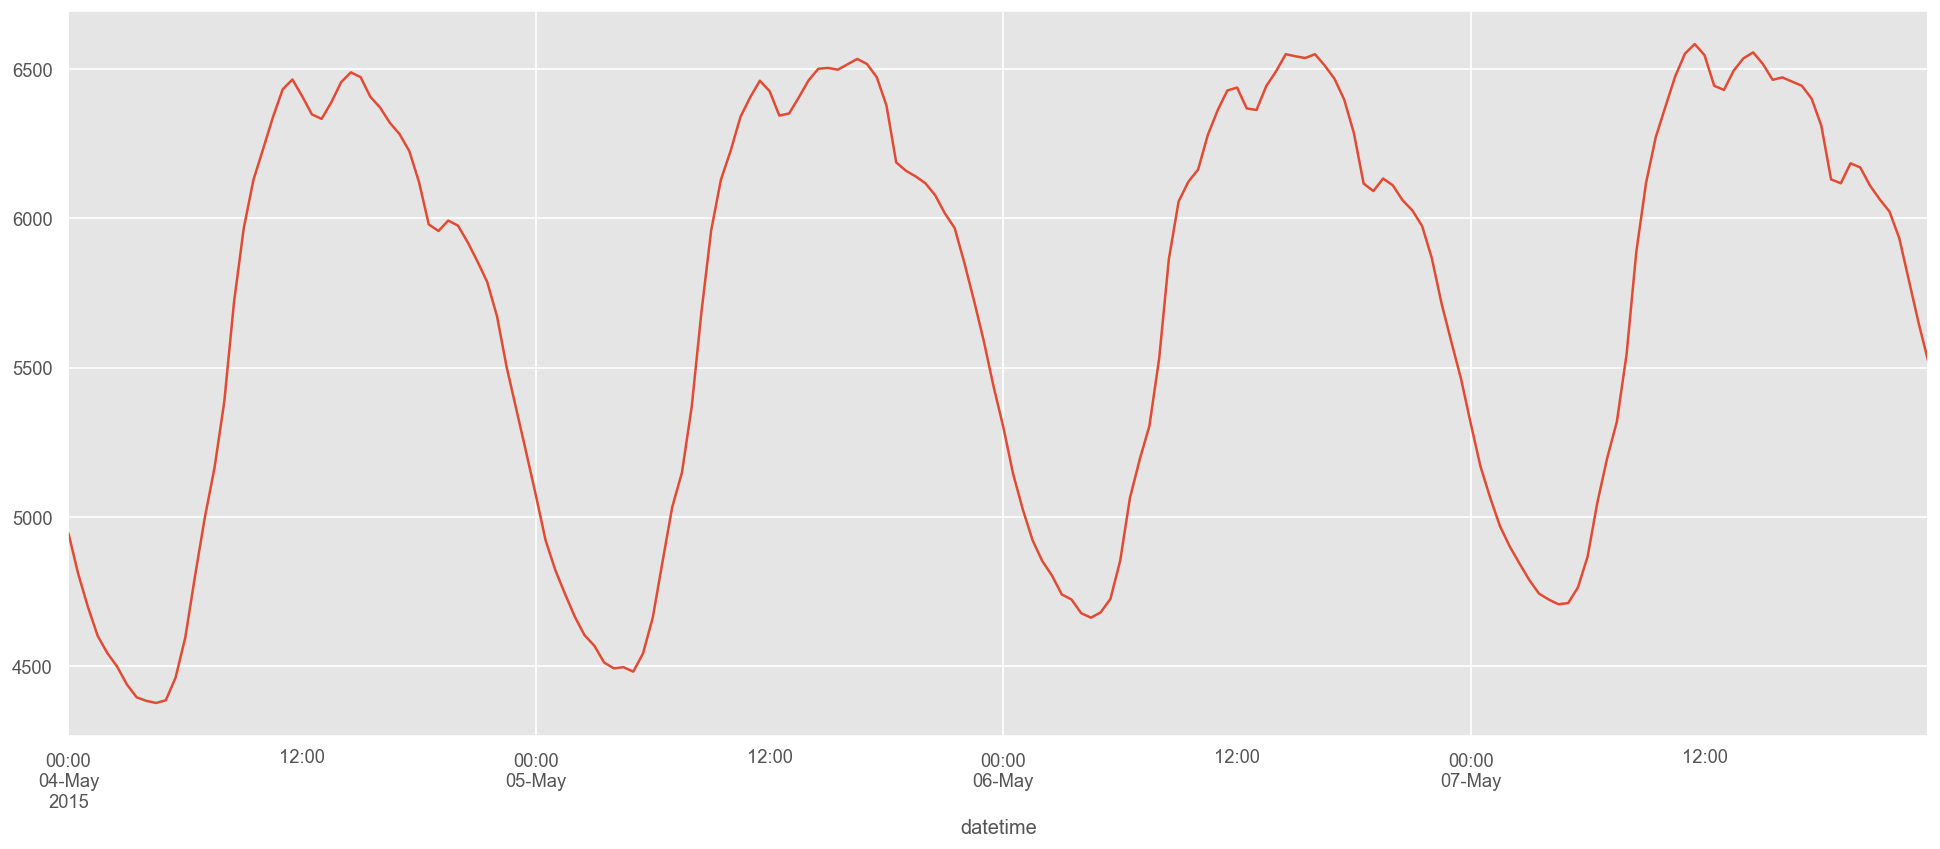

ADF Statistic: -4.289715765397449
p-value: 0.00046278506266978707


In [7]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=FIG_SIZE)

# # Plot time series
demand_data_analysis.nem_demand_actual.plot()
plt.show()

# Run Dicky-Fuller test
result = adfuller(demand_data_analysis.nem_demand_actual)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

**ADF Test Statistic** → 0th element
- More negative means more likely to be stationary

**P-Value** → 1st element
- If p-value is small (< 0.05) → reject null hypothesis. Reject non-stationary.

It is inconclusive whether the time series is stationary although the p-value points to rejecting the null hypothesis that the time series is stationary.

### ARIMA Model Identification

Take a look at the **PACF and ACF** without differencing.  

We will use the ACF and PACF to decide whether some data is best suited to an MA model or an AR model. Selecting the right model order is of great importance to our predictions.  For different types of models we expect the following behavior in the ACF and PACF:

Model|AR(p)|MA(q)|ARMA(p,q)
--|--|--|--
ACF|Tails off|Cuts off after lag q|Tails off
PACF|Cuts off after lag p|Tails off|Tails off


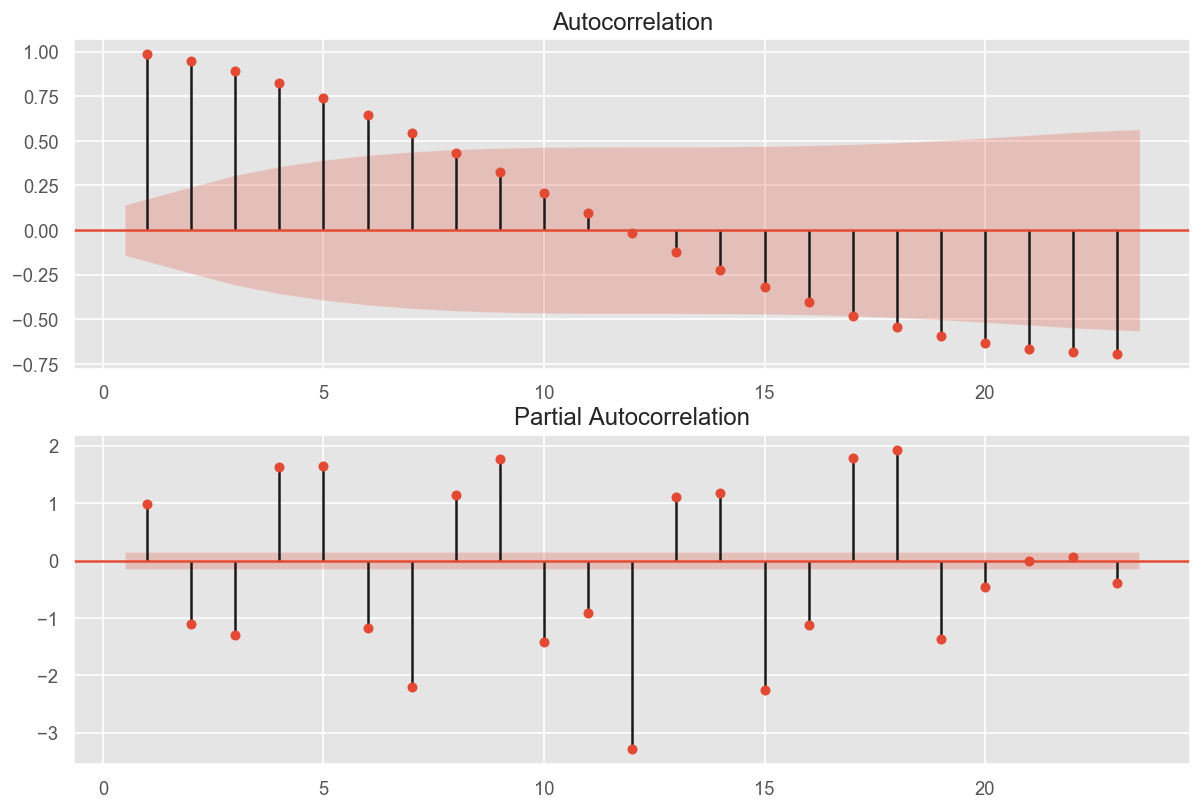

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(demand_data_analysis.nem_demand_actual, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(demand_data_analysis.nem_demand_actual, zero=False, ax=ax2)

plt.show()

The PACF plot does not tails off.  Possibly due to the time series not being stationary.

### Transforming time series by differencing
With differencing, we aim to transform the time series to be stationary.

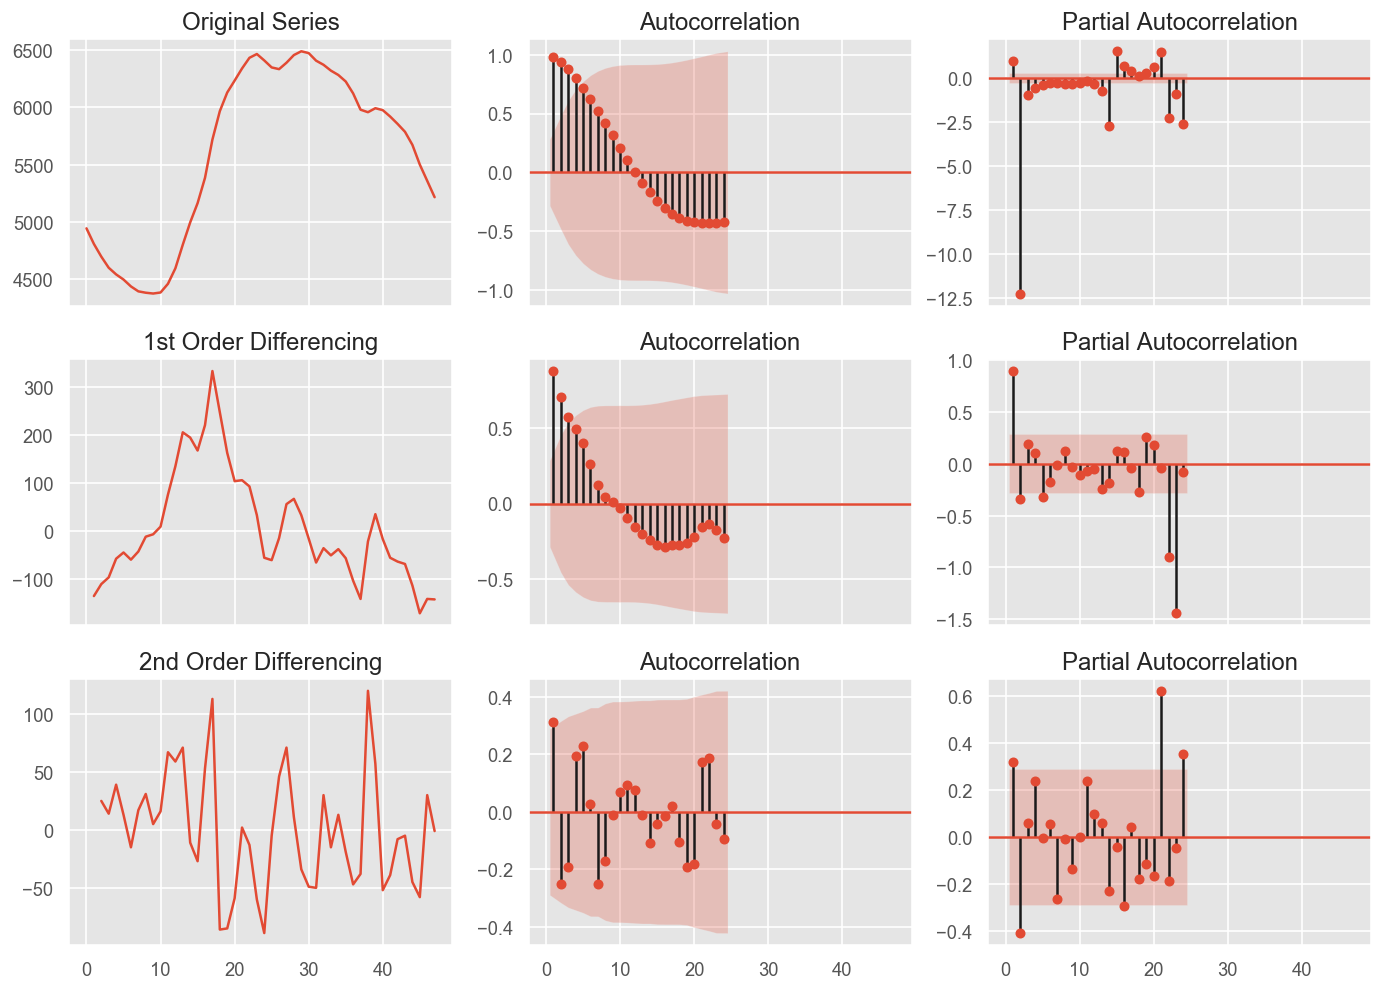

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF_LAGS = demand_data_analysis.shape[0] - 10
ACF_LAGS = 24

# Import data
series = demand_data_analysis.nem_demand_actual.reset_index(drop=True)[0:ACF_LAGS*2]

# Original Series
fig, axes = plt.subplots(3, 3, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
plot_acf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 1])
plot_pacf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 1])
plot_pacf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 1])
plot_pacf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 2])

plt.show()

Conservatively, 1st order differencing looks sufficient.

### Choosing the p and q for the ARIMA model with differencing = 1

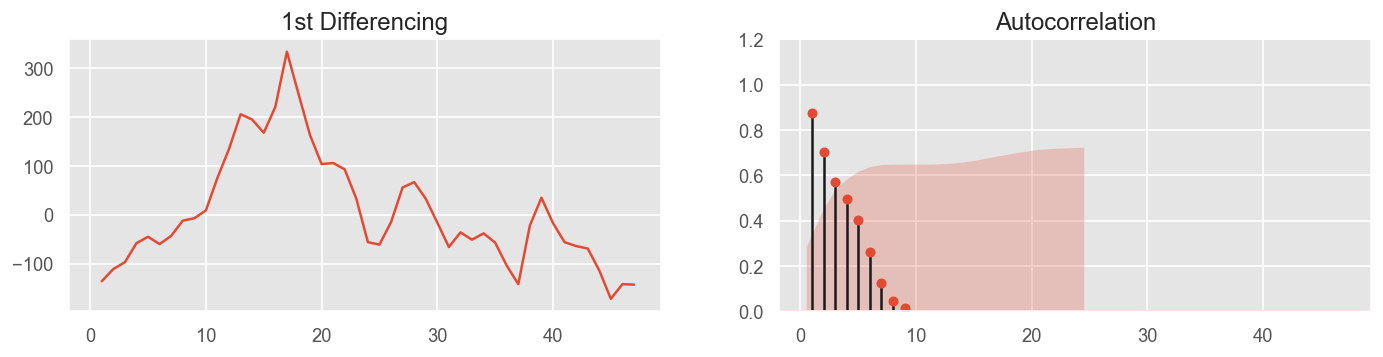

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,3))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(series.diff().dropna(), ax=axes[1], lags=ACF_LAGS, zero=False)

plt.show()

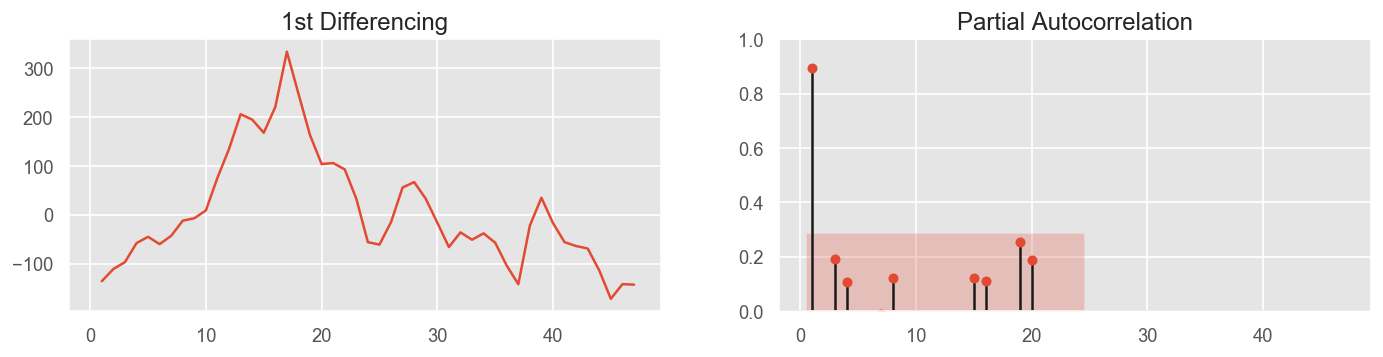

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,3))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(series.diff().dropna(), ax=axes[1], lags=ACF_LAGS, zero=False)

plt.show()

Choosing the following to build the ARIMA model
- d = 1
- p = 1
- q = 1

That is **ARIMA(1,1,1)** model

### Introducing SARIMAX Model
Given the time series has seasonality effect, we will build a SARIMAX model.  We will also iterate through the model parameters to find the best model based on BIC or AIC.

Notes:
1. BIC favors simpler models than AIC
2. AIC is better at choosing predictive models
3. BIC is better at choosing good explanatory mode

Working on the non-seasonal parameters first:
1. p: from 0 to 3
2. d: from 1 to 2
3. q: from 0 to 3

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import data
series = demand_data_analysis.nem_demand_actual.reset_index(drop=True)

# Create empty list to store search results
order_aic_bic=[]

for p in range(4):
    for q in range(4):
        for d in range(1,3):
            print('Processing {},{},{}...'.format(p,d,q))
            # create and fit ARMA(p,d,q) model
            model = SARIMAX(series, order=(p,d,q))
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, d, q, results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'AIC', 'BIC'])

Processing 0,1,0...
Processing 0,2,0...
Processing 0,1,1...
Processing 0,2,1...
Processing 0,1,2...
Processing 0,2,2...
Processing 0,1,3...
Processing 0,2,3...
Processing 1,1,0...
Processing 1,2,0...
Processing 1,1,1...
Processing 1,2,1...
Processing 1,1,2...
Processing 1,2,2...
Processing 1,1,3...
Processing 1,2,3...
Processing 2,1,0...
Processing 2,2,0...
Processing 2,1,1...
Processing 2,2,1...
Processing 2,1,2...
Processing 2,2,2...
Processing 2,1,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,2,3...
Processing 3,1,0...
Processing 3,2,0...
Processing 3,1,1...
Processing 3,2,1...
Processing 3,1,2...
Processing 3,2,2...
Processing 3,1,3...
Processing 3,2,3...


In [13]:
# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head()

,p,d,q,AIC,BIC
23,2,2,3,2024.059358,2043.541502
31,3,2,3,2024.901022,2047.630191
30,3,1,3,2026.644036,2049.409950
22,2,1,3,2029.722849,2049.236489
17,2,2,0,2032.903858,2042.644931


In [14]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').head()

,p,d,q,AIC,BIC
17,2,2,0,2032.903858,2042.644931
23,2,2,3,2024.059358,2043.541502
31,3,2,3,2024.901022,2047.630191
25,3,2,0,2034.901703,2047.889799
19,2,2,1,2034.902436,2047.890532


Best Model based on AIC is **ARIMA(2,2,3)** 

## Model Diagnostics

In [15]:
# Fit model
model = SARIMAX(series, order=(2,2,3))
results = model.fit()

# Assign residuals to variable
residuals = results.resid

How far our the predictions from the real values?

In [16]:
mae = np.mean(np.abs(residuals))
mae

76.2756395774209

If the model fits well the residuals will be white Gaussian noise

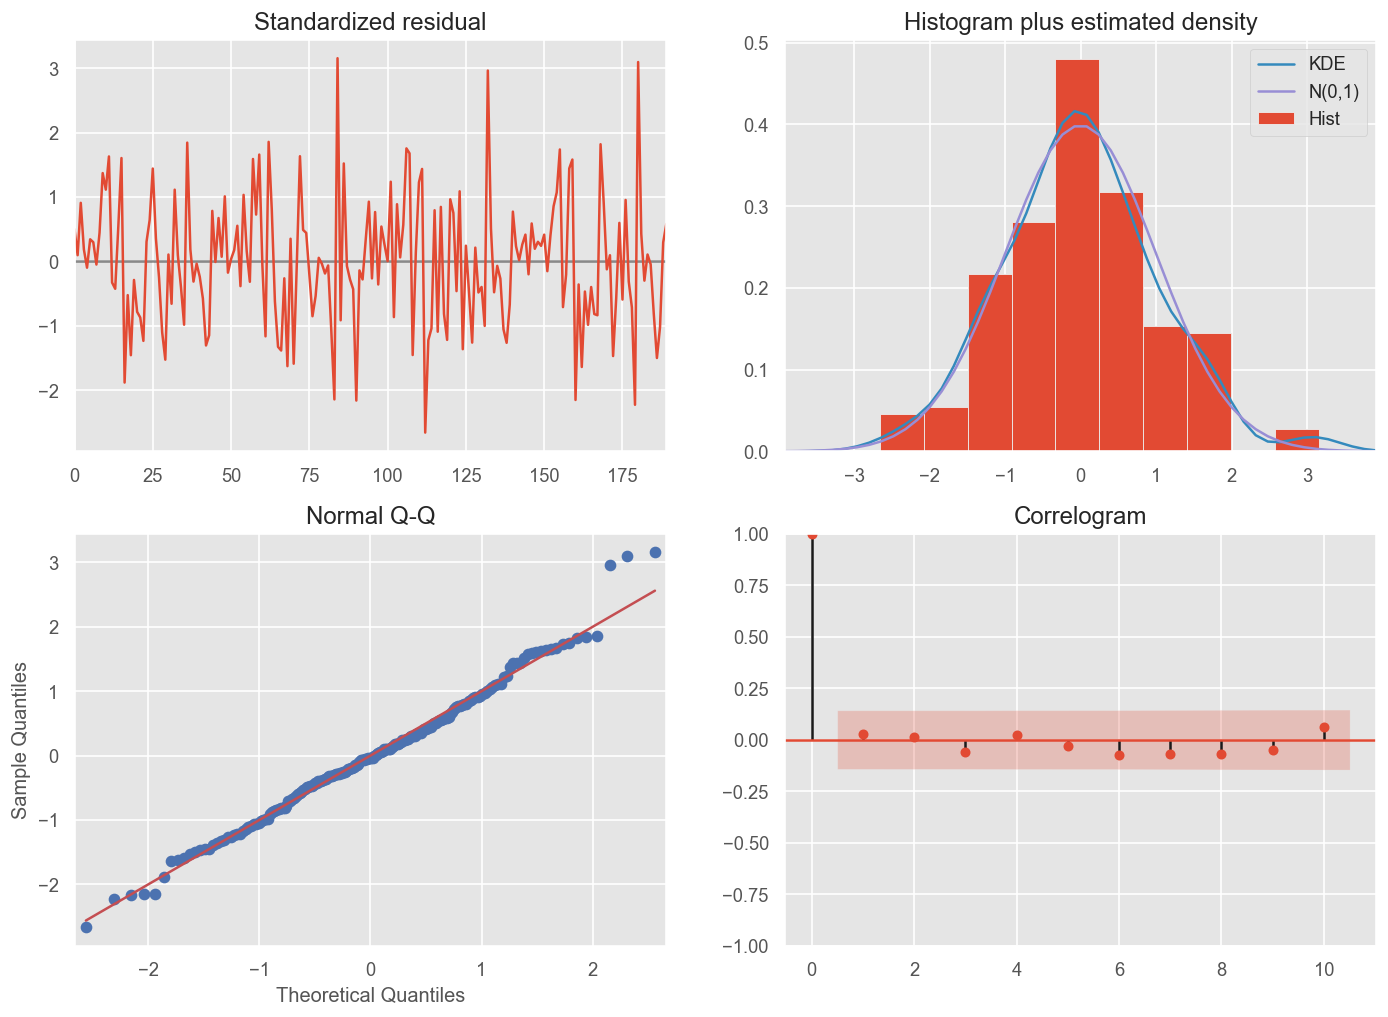

In [17]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(14,10))
plt.show()

If the 2 measures below are below 0.05, we will reject the null hypothesis

Test | Null hypothesis | P-value name | What the p-value mean
--| -- |-- | --
Ljung-Box|There are no correlations in the residual|Prob(Q)|p-value less than 0.05 then REJECT null hypothesis that residuals are uncorrelated 
Jarque-Bera|The residuals are normally distributed|Prob(JB)|p-value less than 0.05 then REJECT null hypothesis that residuals are normal

If any of the null hypothesis is rejected, model can be improved.


In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      nem_demand_actual   No. Observations:                  192
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -1006.030
Date:                Wed, 18 Mar 2020   AIC                           2024.059
Time:                        22:21:49   BIC                           2043.542
Sample:                             0   HQIC                          2031.951
                                - 192                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8918      0.085     10.440      0.000       0.724       1.059
ar.L2         -0.7208      0.090     -8.042      0.000      -0.896      -0.545
ma.L1         -0.7359      0.100     -7.341      0.000      -0.932      -0.539
ma.L2          0.2804      0.129      2.175      0.030       0.028       0.533
ma.L3          0.4127      0.084      4.890      0.000       0.247       0.578
sigma2      2311.8932    243.032      9.513      0.000    1835.560    2788.227
===================================================================================
Ljung-Box (Q):                       88.20   Jarque-Bera (JB):                 3.62
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.32   Skew:                             0.25
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model can be improved.  Let's look at the seasonality paramters.

### How about Seasonal Decomposition?

#### Time Series Decomposition
The frequency of decomposition must be an interval, which 'may' repeat. So we have data with 30min frequency and we are looking for a daily repetition of behavior.

$decompfreq = \cfrac{24h \cdot 60min}{30min} \cdot 1day$

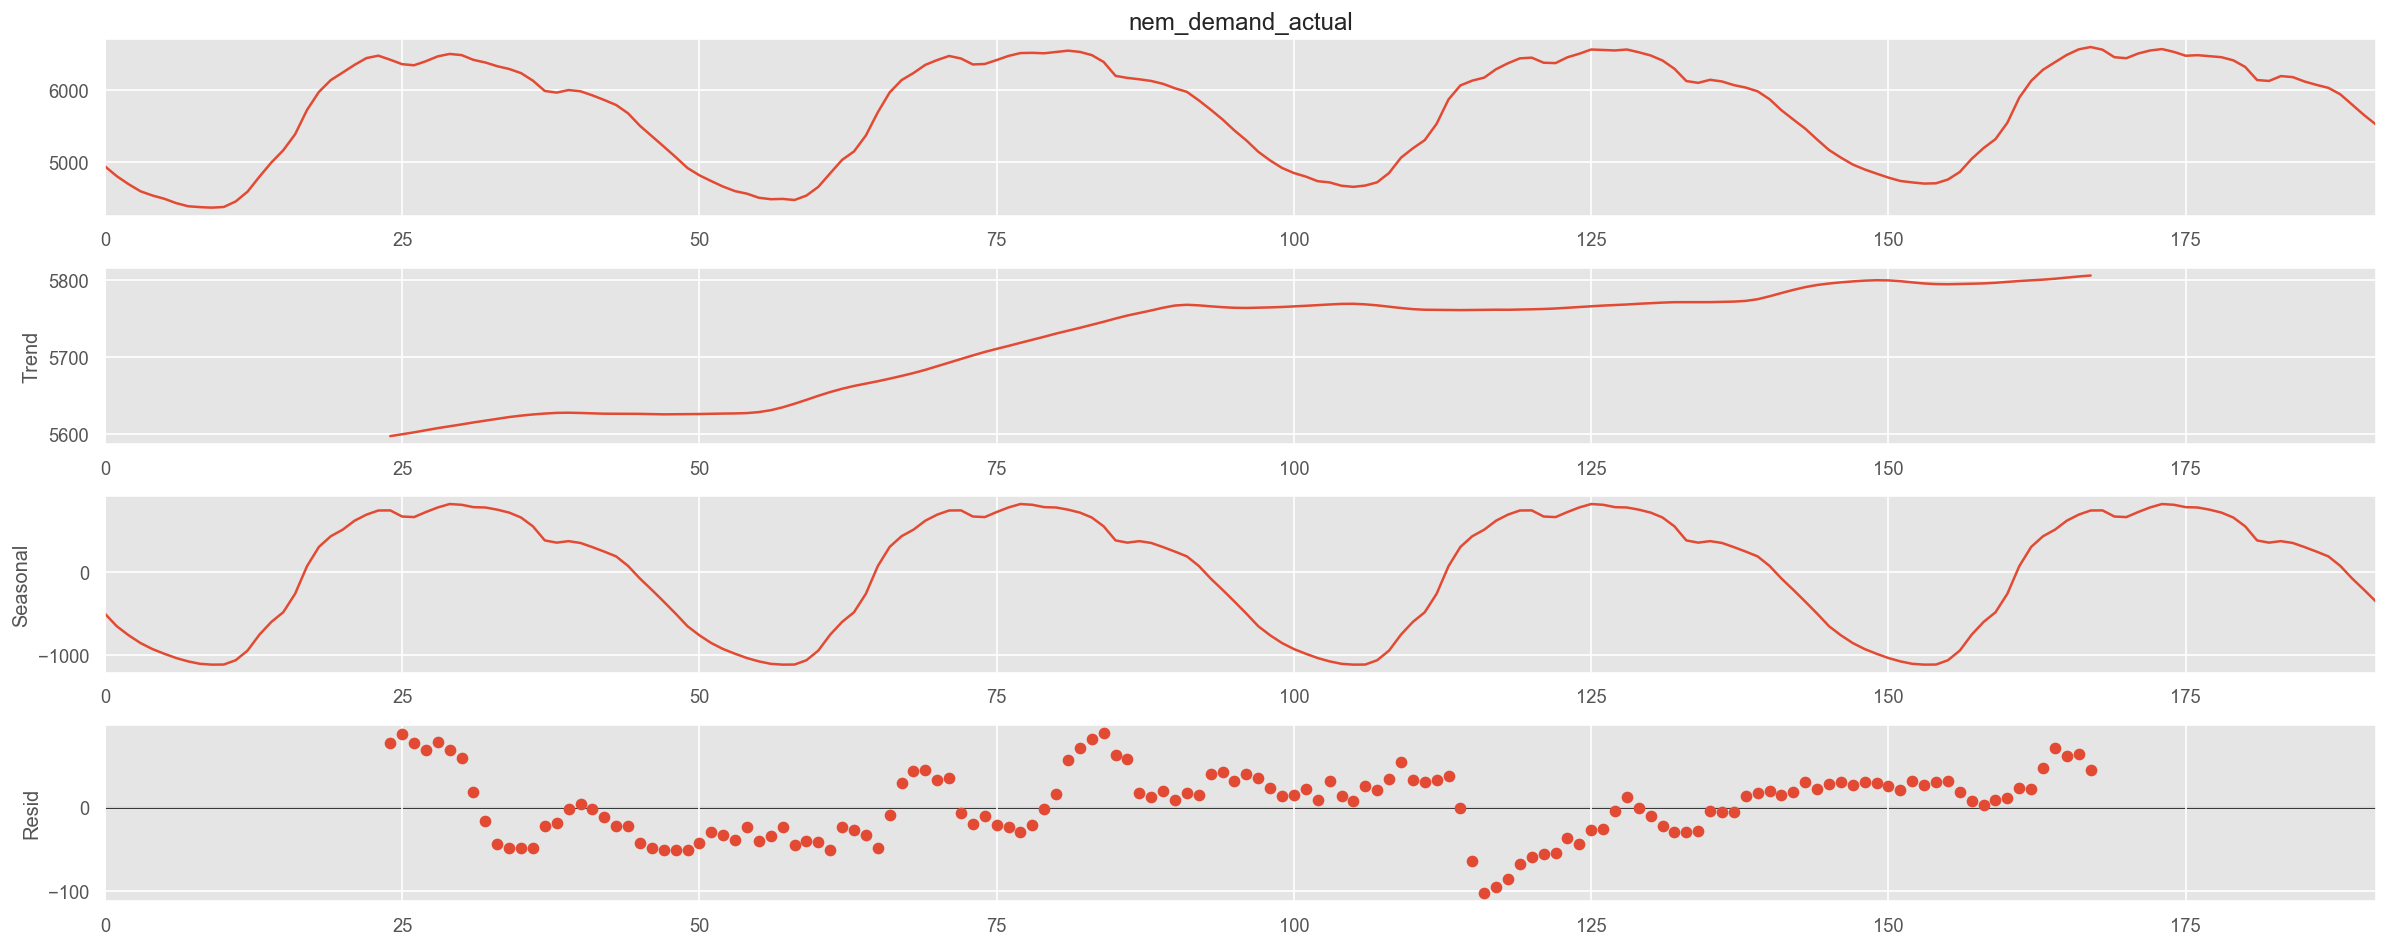

In [19]:
import pylab
pylab.rcParams['figure.figsize'] = FIG_SIZE

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = int(24*60/30*1)

decomp_results = seasonal_decompose(series, freq=decompfreq, model='additive')

decomp_results.plot()
plt.show()

# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,5), sharex=True)
# decomp_results.trend.plot(ax=ax1)
# ax1.set_ylabel("Trend")
# decomp_results.seasonal.plot(ax=ax2)
# ax2.set_ylabel("Seasonal")
# decomp_results.resid.plot(ax=ax3)
# ax3.set_ylabel("Residual")
# plt.show()

### Selecting the seasonality parameters (P,D,Q) for the SARIMAX model
The following parameters are fixed during the iteration:
1. (p,d,q) = (2,2,3)
2. Seasonal Frequency: 48 (48 x 30min for each day, time series to repeat every day)

Parameters to iterate:
1. P: from 0 to 3
2. D: 0 *(Sum of D and d cannot be > 2)*
3. Q: from 0 to 3

In [20]:
print('Seasonal Frequency is {} steps'.format(decompfreq))

Seasonal Frequency is 48 steps


<span style="color:red">**Warning:  Below may take long time to run.**</span>

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

DIFF = decompfreq
ns_order = (2,2,3)

# Import data
series = demand_data_analysis.nem_demand_actual.interpolate().reset_index(drop=True)

# Create empty list to store search results
order_aic_bic_seasonal=[]

for P in range(4):
    for Q in range(4):
        for D in range(1):
            print('Processing {},{},{}...'.format(P,D,Q))

            # create and fit SARIMAX(p,d,q,P,D,Q,DIFF) model
            model = SARIMAX(series, order=ns_order, seasonal_order=(P,D,Q,DIFF))
            try:
                results = model.fit()

                # Append order and results tuple
                order_aic_bic_seasonal.append((P, D, Q, results.aic, results.bic))
            except:
                pass
            
# Construct DataFrame from order_aic_bic
order_seasonal_df = pd.DataFrame(order_aic_bic_seasonal, columns=['P', 'D', 'Q', 'AIC', 'BIC'])

Processing 0,0,0...
Processing 0,0,1...
Processing 0,0,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 0,0,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 1,0,0...
Processing 1,0,1...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 1,0,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 1,0,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,0,0...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,0,1...
Processing 2,0,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 2,0,3...
Processing 3,0,0...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 3,0,1...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 3,0,2...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing 3,0,3...


/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
order_seasonal_df.sort_values('AIC').head()

,P,D,Q,AIC,BIC
10,2,0,3,1829.086433,1864.803698
14,3,0,3,1833.327901,1872.292190
11,3,0,0,1843.089120,1872.312336
12,3,0,1,1845.007555,1877.477796
5,1,0,1,1845.676210,1871.652402


In [23]:
order_seasonal_df.sort_values('BIC').head()

,P,D,Q,AIC,BIC
10,2,0,3,1829.086433,1864.803698
5,1,0,1,1845.676210,1871.652402
14,3,0,3,1833.327901,1872.292190
11,3,0,0,1843.089120,1872.312336
6,1,0,2,1846.619139,1875.842356


Best Model based on AIC is **SARIMAX(2,2,3)x(2,0,3)** with Seasonal Frequency of 48 

In [24]:
# Create a SARIMAX model
model = SARIMAX(series, order=(2,2,3), seasonal_order=(2,0,3,DIFF))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  nem_demand_actual   No. Observations:                  192
Model:             SARIMAX(2, 2, 3)x(2, 0, 3, 48)   Log Likelihood                -903.543
Date:                            Wed, 18 Mar 2020   AIC                           1829.086
Time:                                    22:46:20   BIC                           1864.804
Sample:                                         0   HQIC                          1843.555
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.289      0.754      0.451      -0.348       0.784
ar.L2          0.4873      0.163   

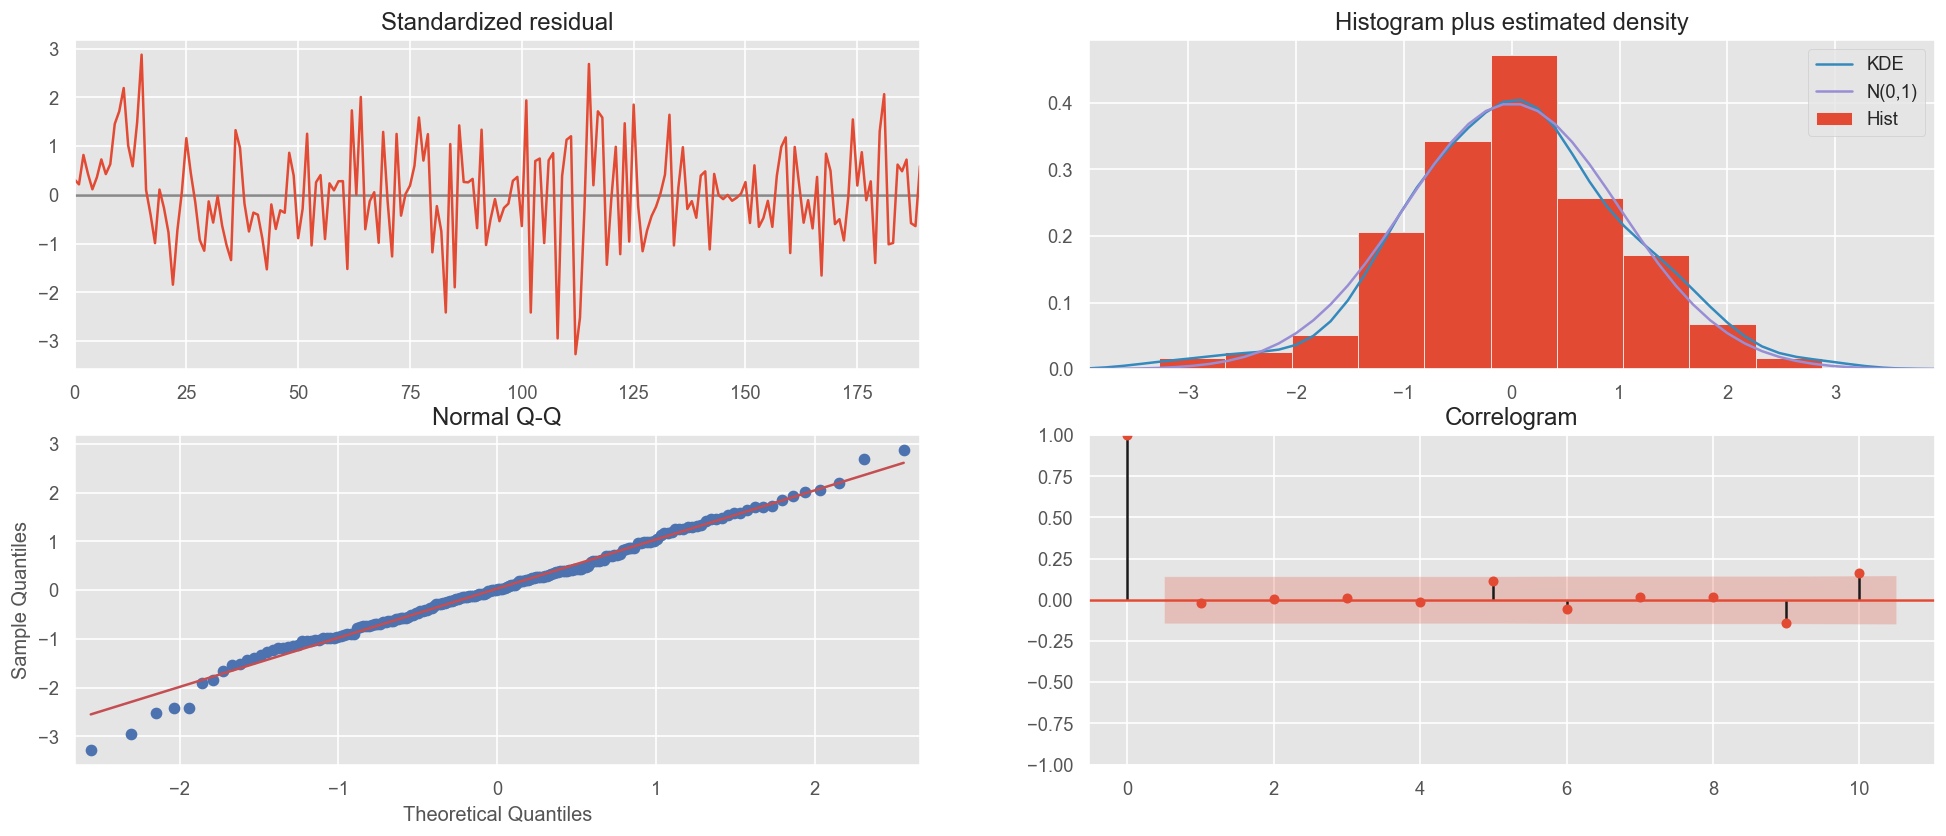

In [25]:
results.plot_diagnostics(figsize=FIG_SIZE)
plt.show()

### Using pmdarima library to search for the best SARIMAX model
Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities.

In [26]:
import pmdarima as pm

Fixing the following parameters:
1. p: from 0 to 3
2. d: 2
3. q: from 0 to 3
4. P: from 0 to 3
5. D: 0
6. Q: from 0 to 3
7. Seasonality Frequency: 48

In [27]:
results_auto = pm.auto_arima(series, d=2, start_p=0, start_q=0, max_p=3, max_q=3, # non-seasonal arguments
                        seasonal=True, m=48, D=0, start_P=0, start_Q=0, max_P=3, max_Q=3,
                        information_criterion='aic', # used to select best model
                        trace=True,                  # print results whilst training
                        error_action='ignore',       # ignore orders that don't work
                        stepwise=True,)

print(results_auto.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 48) (constant=True); AIC=2065.492, BIC=2071.986, Time=0.010 seconds
Fit ARIMA: (1, 2, 0)x(1, 0, 0, 48) (constant=True); AIC=1888.631, BIC=1901.620, Time=1.959 seconds
Near non-invertible roots for order (1, 2, 0)(1, 0, 0, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 2, 1)x(0, 0, 1, 48) (constant=True); AIC=1977.070, BIC=1990.058, Time=1.876 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 1, 48); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 48) (constant=False); AIC=2063.492, BIC=2066.739, Time=0.007 seconds
Fit ARIMA: (0, 2, 0)x(1, 0, 0, 48) (constant=True); AIC=1894.151, BIC=1903.892, Time=1.116 seconds
Near non-invertible roots for order (0, 2, 0)(1, 0, 0, 48); setting score to inf (at least one inverse root too close to the border of the unit

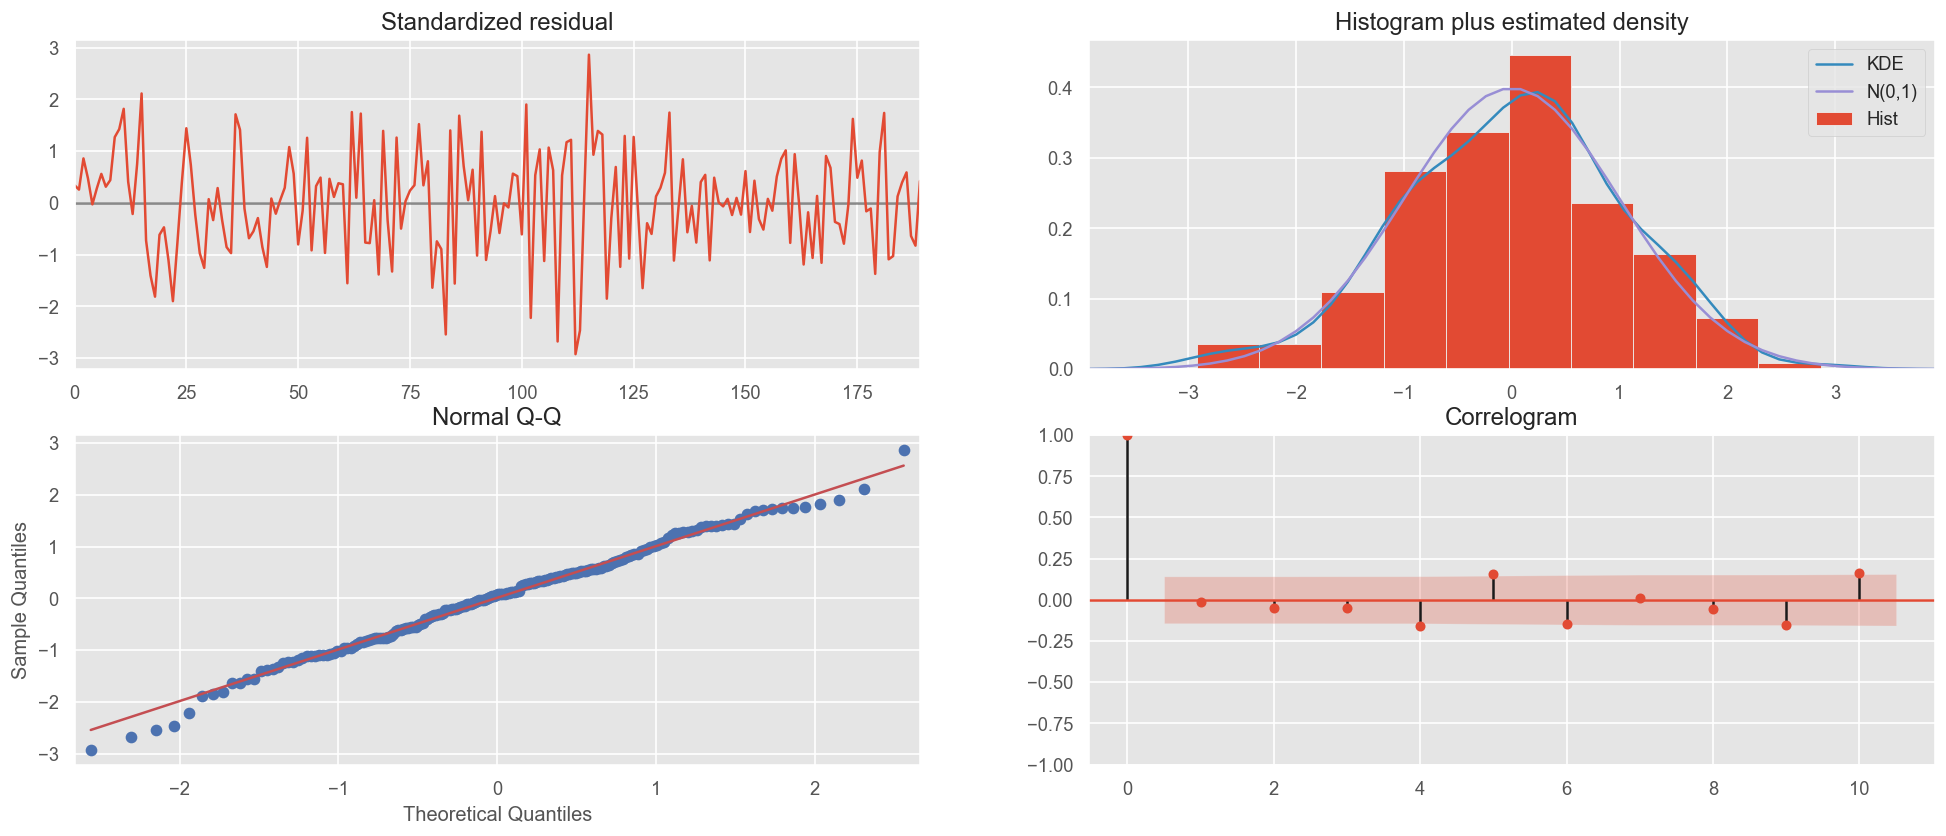

In [28]:
results_auto.plot_diagnostics(figsize = FIG_SIZE)
plt.show()

Although Pyamaria auto arima search suggested **SARIMAX(2, 2, 0)x(1, 0, [1], 48)** as the best model, **SARIMAX(2, 2, 3)x(2, 0, 3, 48)** remains the best model based on better AIC.

## Time Series Prediction and Forecasting

### One-Step Ahead Prediction
*Notes:*
- *Predicting one day worth of data (48 x 30min time intervals)*
- *The **dynamic=False** argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.*

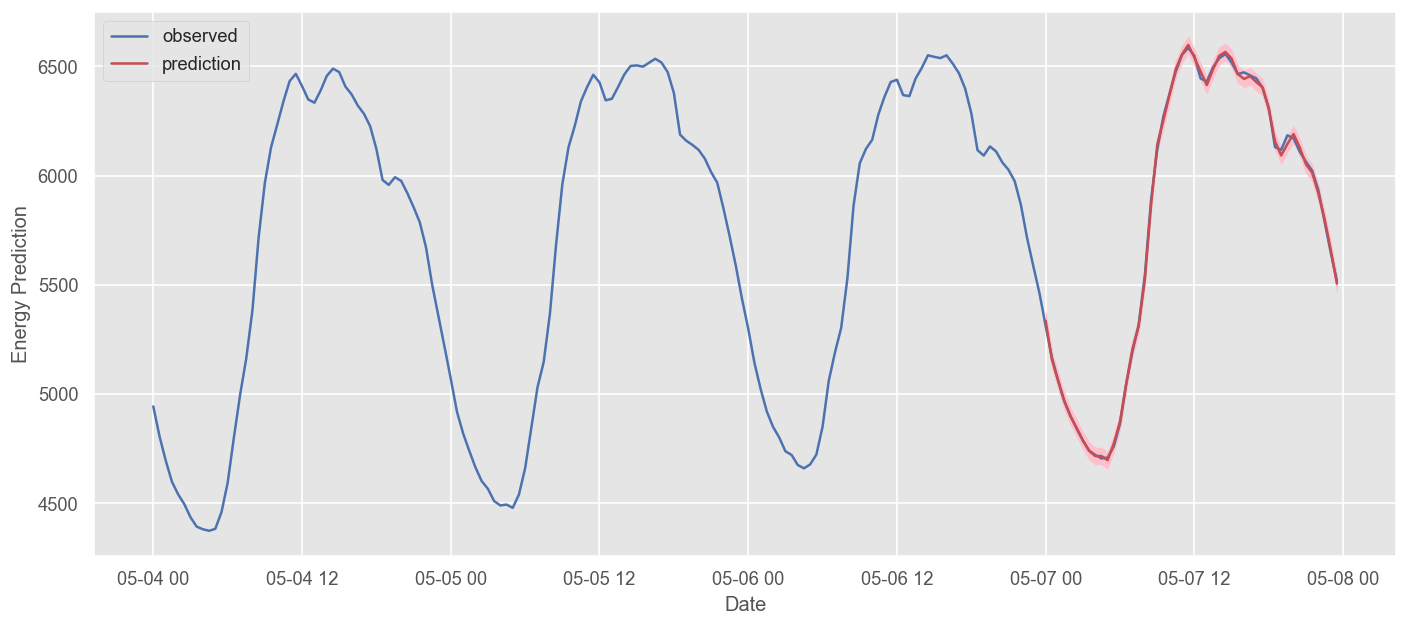

In [35]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
one_step_forecast = results.get_prediction(start=-NUM_OF_STEPS, dynamic=False)
# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='prediction')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

In [36]:
# Compute the mean square error
mse = ((mean_forecast.to_numpy() - series_df[-len(mean_forecast):].to_numpy()) ** 2).mean()
print('The Mean Squared Error of our prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of our prediction is 236.82


While prediction is done based on the most recent in-sample data, the predicted data (red line) is close to the actual data (blue line) and mean squared error is small.

### Dynamic Prediction
*Notes:*
- *Predicting one day worth of data (48 x 30min time intervals)*
- *A better representation of our true predictive power can be obtained using dynamic forecasts (**dynamic=True**).  In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.*

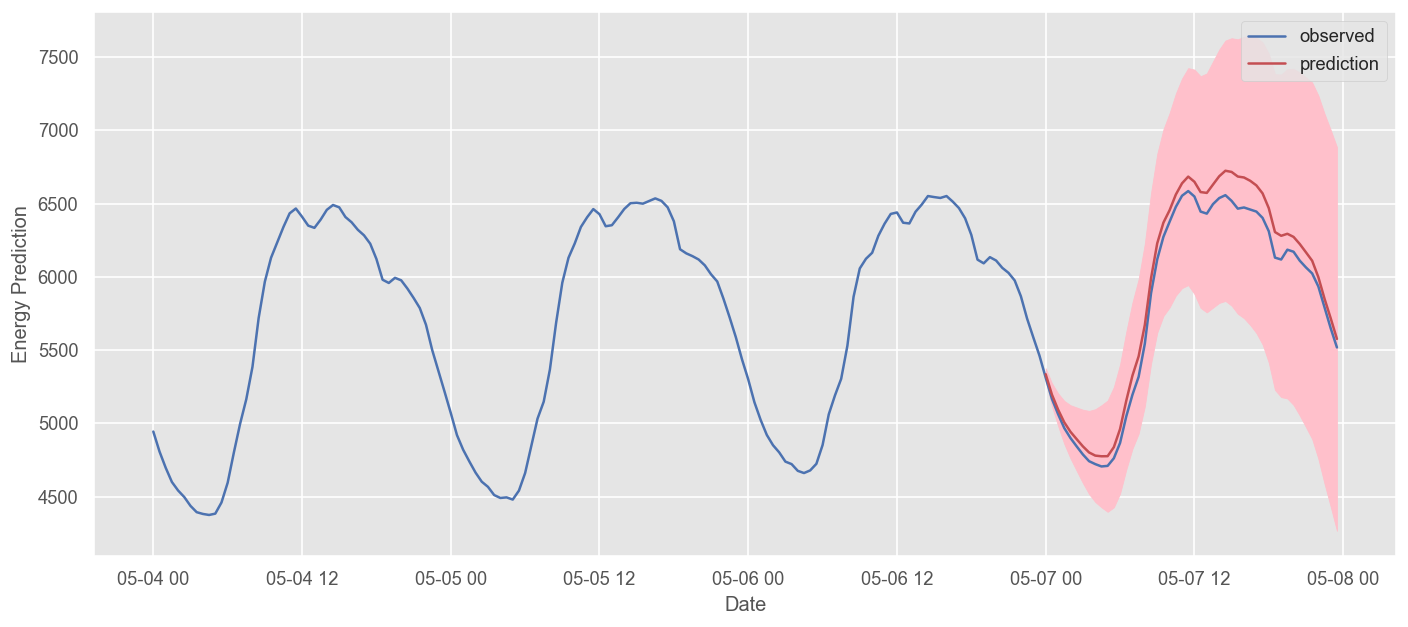

In [37]:
# Import data
series_df = demand_data_analysis.nem_demand_actual

NUM_OF_STEPS = 48
# Generate predictions
dynamic_forecast = results.get_prediction(start=-NUM_OF_STEPS, dynamic=True)
# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = dynamic_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='prediction')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

In [38]:
# Compute the mean square error
mse = ((mean_forecast.to_numpy() - series_df[-len(mean_forecast):].to_numpy()) ** 2).mean()
print('The Mean Squared Error of our prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of our prediction is 13769.15


As expected, the mean squared error dynamic prediction is larger than the one-step ahead prediction given that we are relying on less historical data from the time series.

Confidence intervals are much larger as only in-sample data up to and before the start of the prediction period.  Confidence intervals widens over the prediction period.  Actual data is expected to fall within these intervals.

### Out-Of-Sample Forecast
*Notes:*
- *Forecasting ahead one day worth of data (48 x 30min time intervals)*
- *We are interested in the model's ability to forecast future values way ahead in time.*

In [39]:
PERIOD = '30 min'
FORECAST_DURATION = '1 day'

# Import data
series_df = demand_data_analysis.nem_demand_actual

# Creating the forecast index
from datetime import datetime, timedelta

# Set start and end dates
start = series_df.index[0]
end = series_df.index[-1]
start_forecast = end + pd.Timedelta(PERIOD)
end_forecast = end + pd.Timedelta(FORECAST_DURATION)

# Orginal and forecast index
org_datetime = pd.date_range(start, end, freq=PERIOD)
forecast_datetime = pd.date_range(start_forecast, end_forecast, freq=PERIOD)

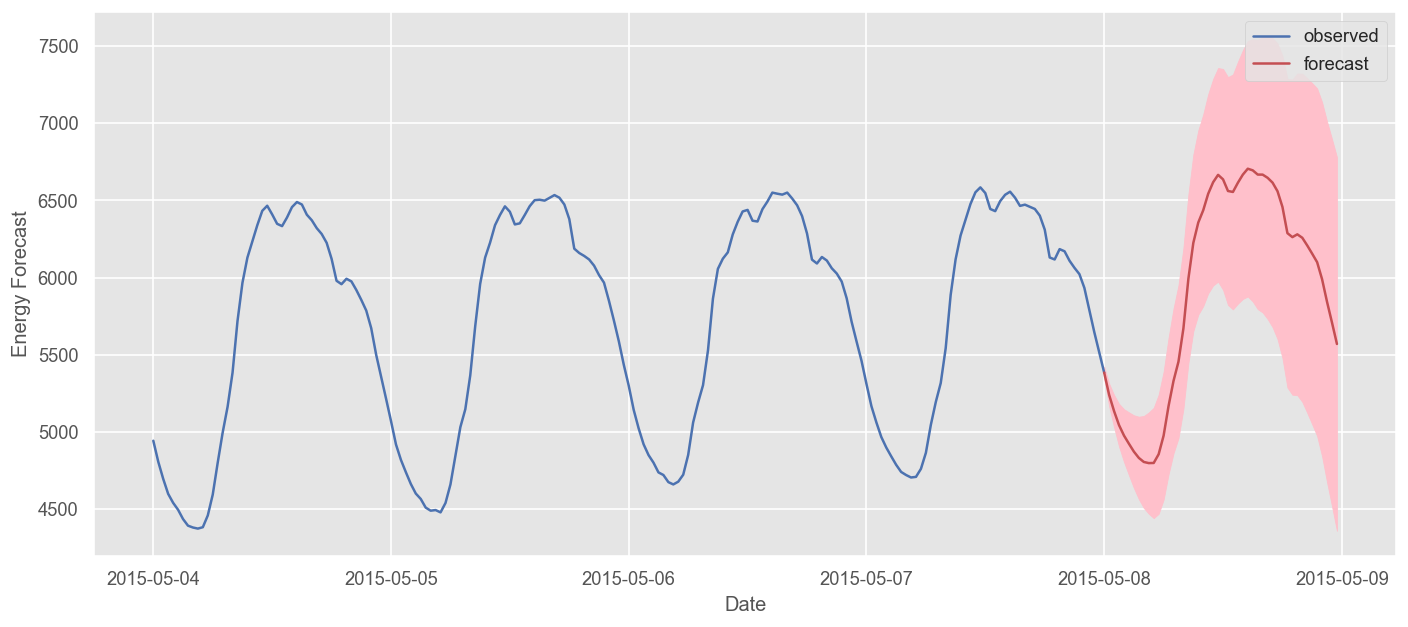

In [40]:
# Preparing the time series plots
NUM_OF_STEPS_AHEAD = len(forecast_datetime)
# Generate predictions
forecast = results.get_forecast(steps=NUM_OF_STEPS_AHEAD)
# Extract prediction mean
mean_forecast = forecast.predicted_mean
mead_forcast_x = forecast_datetime
forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=forecast_datetime, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower nem_demand_actual']
upper_limits = confidence_intervals.loc[:,'upper nem_demand_actual']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=forecast_datetime, 
                           columns = ['lower_limits','upper_limits'])

## Connecting the series
series_df = pd.concat([series_df, forecast_df.forecast])[:len(series_df)+1]

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Forecast')
plt.legend()
plt.show()

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

### Saving the best model

In [29]:
import joblib

# Select a filepath
filepath ='../model/SARIMAX.pkl'

# Save model to filepath
joblib.dump(results, filepath)

### To load the best model

In [31]:
# Select a filepath
filepath ='../model/SARIMAX.pkl'

# Load model object from filepath
results = joblib.load(filepath)

## Reference
1. https://data.gov.sg/dataset/half-hourly-system-demand
2. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/